# Import modules

In [201]:
import warnings
warnings.filterwarnings('ignore')

In [202]:
import pandas as pd
import numpy as np
from numpy import arange
import matplotlib.pyplot as plt
import sklearn
import os
import dill as pickle
from itertools import combinations
import random
import tensorflow as tf
import keras
from keras.models import Model, Input, Sequential, load_model
from keras.applications.vgg16 import VGG16
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.layers import Input, Conv2D, Lambda, merge, Dense, Flatten, MaxPooling2D, ZeroPadding2D, Dropout
from keras.optimizers import SGD,Adam
import keras.metrics
from keras.utils import plot_model
from src.models import history
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import librosa
from IPython.display import Audio
from sklearn.metrics import average_precision_score

from src.data import process_audio
from src.data import display_audio
from src.data import process_audio_siam
from src.models import one_shot_learning
from src.data import process_audio_VGG16_features
from src.models import one_shot_learning_VGG16
from src.data import audio_to_features
from src.data import features_for_model
from src.models import one_shot_learning
from src.models import applications


In [203]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Siamese_same_weights

In [9]:
# One dense layer
input_shape = (7, 7, 512)   

inputs = Input(input_shape)
output = Flatten()(inputs) 
encodings = Dense(4096, activation='sigmoid')(output)


one_dense = Model(inputs=inputs, outputs=encodings, name='one_dense')
one_dense.compile(optimizer=Adam(lr = 0.00006), 
                  loss='categorical_crossentropy')


# Define tensors for two input audios
input_shape = (7, 7, 512)

left_input = Input(input_shape)
right_input = Input(input_shape)    

encoded_l = one_dense(left_input)
encoded_r = one_dense(right_input)

# Add a customized layer to compute the difference between the vectors/encodings
L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
L1_distance = L1_layer([encoded_l, encoded_r])
    
# Add a layer to classify the audios into "same speaker" = 1 or "not the same" = 0
classification = Dense(1,activation='sigmoid')(L1_distance)
    
# Siamese model
siamese_same_weights = Model(inputs=[left_input,right_input],outputs=classification)

# Adam optimizer
siamese_same_weights.compile(optimizer=Adam(lr = 0.00006),
            loss='binary_crossentropy', 
              metrics=['accuracy'])

Instructions for updating:
Colocations handled automatically by placer.


In [10]:
# Model architecture is the same. Loading weights from the previous training.
weights = '/Users/greenapple/project5/notebooks/siamese_same_weights_bal_900.h5'
model = siamese_same_weights
model.load_weights(weights)

# Speaker identification

In [20]:
# Load data:
# Train data
data_900 = pickle.load(open(
    '/Users/greenapple/project5/data/processed/train_data_900.pkl', 'rb'
))

# Test data
test_data_40 = pickle.load(
    open('/Users/greenapple/project5/data/processed/test_data_40.pkl', 'rb')
)

test_data_40_vgg = pickle.load(
    open('/Users/greenapple/project5/data/processed/test_data_40_vgg.pkl', 'rb')
)

# Vaidation data
val_data_40_vgg = pickle.load(open(
'/Users/greenapple/project5/data/processed/val_data_40_vgg.pkl', 'rb'))

# Logreg

## Getting the functions ready

In [11]:
# Same speaker
model = siamese_same_weights
trials = 1
speaker_data = test_data_40_vgg

lst = applications.one_speaker_authentification_1(model, trials, speaker_data)
lst

array([[0.989847  ],
       [0.9999076 ],
       [0.9986553 ],
       [0.9996468 ],
       [0.99813265]], dtype=float32)

In [12]:
# Different speaker
model = siamese_same_weights
trials = 1
speaker_data = test_data_40_vgg

lst = applications.one_speaker_authentification_0(model, trials, speaker_data)
lst

array([[8.8924270e-07],
       [5.8117709e-03],
       [3.0307487e-02],
       [3.3256428e-03],
       [2.7437600e-01]], dtype=float32)

In [64]:
len(lst)

5

## 5 audios per voiceprint

In [97]:
# Generate data for logreg
data = pd.DataFrame()
features = []
targets = []

model = siamese_same_weights
trials = 1
speaker_data = test_data_40_vgg
count = 0
for i in range(2000):
    p = applications.one_speaker_authentification_1(model, trials, speaker_data)
    n = applications.one_speaker_authentification_0(model, trials, speaker_data)
   
    features.append(p)
    features.append(n)
    targets.append(1)
    targets.append(0)
    
    count+=1
    print('Collecting data point {}'.format(count), end='\r')
    
data['features'] =  features
data['targets'] =  targets

In [98]:
data.shape

(4000, 2)

In [99]:
pickle.dump(data, open(
    '/Users/greenapple/project5/data/processed/logreg_data_2000.pkl', 'wb'))

In [171]:
data = pickle.load(open(
    '/Users/greenapple/project5/data/processed/logreg_data_2000.pkl', 'rb'))

In [172]:
data.features[0].tolist()

[[0.4032413065433502],
 [0.4501464068889618],
 [0.5415229201316833],
 [0.25278207659721375],
 [0.9546958804130554]]

In [173]:
# Train, test split
train_data = data[:3600]
test_data = data[3600:]

In [99]:
train_data.shape, test_data.shape

((3600, 2), (400, 2))

In [100]:
# Reshape data for training
X = np.array(train_data.features.tolist()).reshape(3600, 5)
y = np.array(train_data.targets.tolist())

X_val = np.array(test_data.features.tolist()).reshape(400, 5)
y_val = np.array(test_data.targets.tolist())

In [101]:
X.shape, y.shape

((3600, 5), (3600,))

In [103]:
# Logistic regression
inputs = Input(shape=(5,))
output = Dense(1, activation='sigmoid')(inputs)
logreg = Model(inputs, output)

logreg.compile(optimizer=Adam(lr = 0.0001),
                       loss = 'binary_crossentropy',
                       metrics=['accuracy'])

In [104]:
early_stp = EarlyStopping(monitor='val_loss', 
                          min_delta=0, patience=5, 
                          verbose=1, mode='auto', 
                          baseline=None, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0000001)

# model.fit(X_train, Y_train, callbacks=[reduce_lr])

model = logreg
history = logreg.fit(X, y, 
                     epochs = 2000,
                     validation_data = (X_val, y_val),
                     callbacks=[reduce_lr, early_stp])

Train on 3600 samples, validate on 400 samples
Epoch 1/2000
3600/3600 [==============================] - 1s 156us/step - loss: 0.6955 - acc: 0.5936 - val_loss: 0.6565 - val_acc: 0.6575
Epoch 2/2000
3600/3600 [==============================] - 0s 35us/step - loss: 0.6918 - acc: 0.6111 - val_loss: 0.6531 - val_acc: 0.6800
Epoch 3/2000
3600/3600 [==============================] - 0s 47us/step - loss: 0.6883 - acc: 0.6219 - val_loss: 0.6500 - val_acc: 0.6875
Epoch 4/2000
3600/3600 [==============================] - 0s 39us/step - loss: 0.6849 - acc: 0.6344 - val_loss: 0.6469 - val_acc: 0.6950
Epoch 5/2000
3600/3600 [==============================] - 0s 44us/step - loss: 0.6817 - acc: 0.6414 - val_loss: 0.6440 - val_acc: 0.7025
Epoch 6/2000
3600/3600 [==============================] - 0s 43us/step - loss: 0.6785 - acc: 0.6486 - val_loss: 0.6411 - val_acc: 0.7050
Epoch 7/2000
3600/3600 [==============================] - 0s 35us/step - loss: 0.6755 - acc: 0.6500 - val_loss: 0.6385 - val_acc: 

3600/3600 [==============================] - 0s 36us/step - loss: 0.5818 - acc: 0.7378 - val_loss: 0.5574 - val_acc: 0.7675
Epoch 61/2000
3600/3600 [==============================] - 0s 33us/step - loss: 0.5806 - acc: 0.7389 - val_loss: 0.5564 - val_acc: 0.7675
Epoch 62/2000
3600/3600 [==============================] - 0s 33us/step - loss: 0.5794 - acc: 0.7386 - val_loss: 0.5553 - val_acc: 0.7675
Epoch 63/2000
3600/3600 [==============================] - 0s 32us/step - loss: 0.5782 - acc: 0.7392 - val_loss: 0.5543 - val_acc: 0.7650
Epoch 64/2000
3600/3600 [==============================] - 0s 35us/step - loss: 0.5770 - acc: 0.7394 - val_loss: 0.5534 - val_acc: 0.7650
Epoch 65/2000
3600/3600 [==============================] - 0s 36us/step - loss: 0.5758 - acc: 0.7394 - val_loss: 0.5524 - val_acc: 0.7650
Epoch 66/2000
3600/3600 [==============================] - 0s 33us/step - loss: 0.5746 - acc: 0.7408 - val_loss: 0.5514 - val_acc: 0.7650
Epoch 67/2000
3600/3600 [=======================

3600/3600 [==============================] - 0s 39us/step - loss: 0.5258 - acc: 0.7686 - val_loss: 0.5113 - val_acc: 0.7900
Epoch 120/2000
3600/3600 [==============================] - 0s 36us/step - loss: 0.5251 - acc: 0.7700 - val_loss: 0.5107 - val_acc: 0.7875
Epoch 121/2000
3600/3600 [==============================] - 0s 33us/step - loss: 0.5244 - acc: 0.7706 - val_loss: 0.5101 - val_acc: 0.7875
Epoch 122/2000
3600/3600 [==============================] - 0s 36us/step - loss: 0.5237 - acc: 0.7706 - val_loss: 0.5095 - val_acc: 0.7900
Epoch 123/2000
3600/3600 [==============================] - 0s 39us/step - loss: 0.5230 - acc: 0.7708 - val_loss: 0.5090 - val_acc: 0.7900
Epoch 124/2000
3600/3600 [==============================] - 0s 38us/step - loss: 0.5223 - acc: 0.7717 - val_loss: 0.5084 - val_acc: 0.7900
Epoch 125/2000
3600/3600 [==============================] - 0s 32us/step - loss: 0.5216 - acc: 0.7714 - val_loss: 0.5079 - val_acc: 0.7900
Epoch 126/2000
3600/3600 [================

3600/3600 [==============================] - 0s 34us/step - loss: 0.4936 - acc: 0.7808 - val_loss: 0.4862 - val_acc: 0.7900
Epoch 179/2000
3600/3600 [==============================] - 0s 35us/step - loss: 0.4932 - acc: 0.7811 - val_loss: 0.4859 - val_acc: 0.7900
Epoch 180/2000
3600/3600 [==============================] - 0s 34us/step - loss: 0.4928 - acc: 0.7811 - val_loss: 0.4856 - val_acc: 0.7900
Epoch 181/2000
3600/3600 [==============================] - 0s 34us/step - loss: 0.4924 - acc: 0.7811 - val_loss: 0.4853 - val_acc: 0.7900
Epoch 182/2000
3600/3600 [==============================] - 0s 38us/step - loss: 0.4920 - acc: 0.7808 - val_loss: 0.4850 - val_acc: 0.7900
Epoch 183/2000
3600/3600 [==============================] - 0s 36us/step - loss: 0.4917 - acc: 0.7811 - val_loss: 0.4847 - val_acc: 0.7875
Epoch 184/2000
3600/3600 [==============================] - 0s 33us/step - loss: 0.4913 - acc: 0.7811 - val_loss: 0.4845 - val_acc: 0.7875
Epoch 185/2000
3600/3600 [================

3600/3600 [==============================] - 0s 35us/step - loss: 0.4766 - acc: 0.7833 - val_loss: 0.4743 - val_acc: 0.7900
Epoch 238/2000
3600/3600 [==============================] - 0s 35us/step - loss: 0.4764 - acc: 0.7833 - val_loss: 0.4742 - val_acc: 0.7900
Epoch 239/2000
3600/3600 [==============================] - 0s 36us/step - loss: 0.4762 - acc: 0.7833 - val_loss: 0.4740 - val_acc: 0.7900
Epoch 240/2000
3600/3600 [==============================] - 0s 35us/step - loss: 0.4760 - acc: 0.7839 - val_loss: 0.4739 - val_acc: 0.7900
Epoch 241/2000
3600/3600 [==============================] - 0s 39us/step - loss: 0.4758 - acc: 0.7839 - val_loss: 0.4738 - val_acc: 0.7900
Epoch 242/2000
3600/3600 [==============================] - 0s 41us/step - loss: 0.4756 - acc: 0.7839 - val_loss: 0.4737 - val_acc: 0.7900
Epoch 243/2000
3600/3600 [==============================] - 0s 38us/step - loss: 0.4754 - acc: 0.7839 - val_loss: 0.4735 - val_acc: 0.7900
Epoch 244/2000
3600/3600 [================

3600/3600 [==============================] - 0s 37us/step - loss: 0.4678 - acc: 0.7833 - val_loss: 0.4691 - val_acc: 0.7875
Epoch 297/2000
3600/3600 [==============================] - 0s 38us/step - loss: 0.4677 - acc: 0.7833 - val_loss: 0.4690 - val_acc: 0.7875
Epoch 298/2000
3600/3600 [==============================] - 0s 35us/step - loss: 0.4676 - acc: 0.7833 - val_loss: 0.4690 - val_acc: 0.7875
Epoch 299/2000
3600/3600 [==============================] - 0s 38us/step - loss: 0.4675 - acc: 0.7836 - val_loss: 0.4689 - val_acc: 0.7850
Epoch 300/2000
3600/3600 [==============================] - 0s 38us/step - loss: 0.4673 - acc: 0.7833 - val_loss: 0.4688 - val_acc: 0.7850
Epoch 301/2000
3600/3600 [==============================] - 0s 35us/step - loss: 0.4672 - acc: 0.7831 - val_loss: 0.4688 - val_acc: 0.7850
Epoch 302/2000
3600/3600 [==============================] - 0s 35us/step - loss: 0.4671 - acc: 0.7833 - val_loss: 0.4687 - val_acc: 0.7850
Epoch 303/2000
3600/3600 [================

3600/3600 [==============================] - 0s 37us/step - loss: 0.4633 - acc: 0.7817 - val_loss: 0.4670 - val_acc: 0.7875
Epoch 356/2000
3600/3600 [==============================] - 0s 37us/step - loss: 0.4632 - acc: 0.7817 - val_loss: 0.4670 - val_acc: 0.7875
Epoch 357/2000
3600/3600 [==============================] - 0s 37us/step - loss: 0.4632 - acc: 0.7817 - val_loss: 0.4670 - val_acc: 0.7875
Epoch 358/2000
3600/3600 [==============================] - 0s 37us/step - loss: 0.4632 - acc: 0.7817 - val_loss: 0.4670 - val_acc: 0.7875
Epoch 359/2000
3600/3600 [==============================] - 0s 39us/step - loss: 0.4632 - acc: 0.7817 - val_loss: 0.4670 - val_acc: 0.7875
Epoch 360/2000
3600/3600 [==============================] - 0s 38us/step - loss: 0.4632 - acc: 0.7817 - val_loss: 0.4670 - val_acc: 0.7875
Epoch 361/2000
3600/3600 [==============================] - 0s 36us/step - loss: 0.4632 - acc: 0.7817 - val_loss: 0.4670 - val_acc: 0.7875
Epoch 362/2000
3600/3600 [================

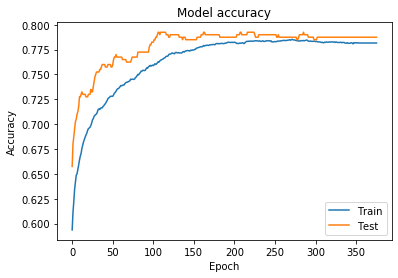

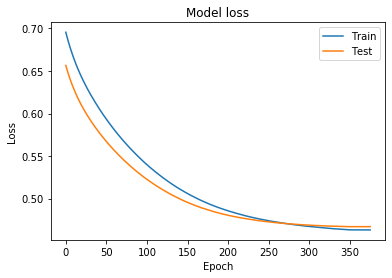

In [105]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='lower right')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

## n audios per voiceprint: 9 audios

In [77]:
# Generate data for logreg
data_10 = pd.DataFrame()
features = []
targets = []

model = siamese_same_weights
trials = 1
speaker_data = test_data_40_vgg
n = 9
count = 0
for i in range(2000):
    pos = applications.one_speaker_authentification_1(model, 
                                                    trials, 
                                                    speaker_data,
                                                    n)
    neg = applications.one_speaker_authentification_0(model, 
                                                    trials, 
                                                    speaker_data,
                                                    n)
   
    features.append(pos)
    features.append(neg)
    targets.append(1)
    targets.append(0)
    
    count+=1
    print('Collecting data point {}'.format(count), end='\r')
    
data_10['features'] =  features
data_10['targets'] =  targets

In [78]:
data_10.shape

(4000, 2)

In [79]:
pickle.dump(data, open(
    '/Users/greenapple/project5/data/processed/logreg_data_5_voiceprint.pkl', 'wb'))

In [142]:
data_10.features[0]

array([[0.98407257],
       [0.94110346],
       [0.14724365],
       [0.86359453],
       [0.9936683 ],
       [0.9948666 ],
       [0.9411349 ],
       [0.67870533],
       [0.97381264]], dtype=float32)

In [143]:
# Train, test split
train_data = data_10[:3600]
test_data = data_10[3600:]

In [144]:
train_data.shape, test_data.shape

((3600, 2), (400, 2))

In [83]:
X = np.array(train_data.features.tolist())
X.shape

(3600, 9, 1)

In [84]:
# Reshape data for training
X = np.array(train_data.features.tolist()).reshape(3600, 9)
y = np.array(train_data.targets.tolist())

X_val = np.array(test_data.features.tolist()).reshape(400, 9)
y_val = np.array(test_data.targets.tolist())

In [94]:
# Logistic regression
inputs = Input(shape=(9,))
output = Dense(1, activation='sigmoid')(inputs)
logreg = Model(inputs, output)

logreg.compile(optimizer=Adam(lr = 0.0001),
                       loss = 'binary_crossentropy',
                       metrics=['accuracy'])

Train on 3600 samples, validate on 400 samples
Epoch 1/2000
3600/3600 [==============================] - 0s 135us/step - loss: 0.7101 - acc: 0.4850 - val_loss: 0.7222 - val_acc: 0.5125
Epoch 2/2000
3600/3600 [==============================] - 0s 33us/step - loss: 0.7012 - acc: 0.5242 - val_loss: 0.7143 - val_acc: 0.5475
Epoch 3/2000
3600/3600 [==============================] - 0s 35us/step - loss: 0.6931 - acc: 0.5803 - val_loss: 0.7073 - val_acc: 0.5700
Epoch 4/2000
3600/3600 [==============================] - 0s 35us/step - loss: 0.6857 - acc: 0.6022 - val_loss: 0.7009 - val_acc: 0.5900
Epoch 5/2000
3600/3600 [==============================] - 0s 37us/step - loss: 0.6790 - acc: 0.6183 - val_loss: 0.6950 - val_acc: 0.5875
Epoch 6/2000
3600/3600 [==============================] - 0s 44us/step - loss: 0.6727 - acc: 0.6353 - val_loss: 0.6895 - val_acc: 0.6025
Epoch 7/2000
3600/3600 [==============================] - 0s 44us/step - loss: 0.6670 - acc: 0.6444 - val_loss: 0.6846 - val_acc: 

3600/3600 [==============================] - 0s 33us/step - loss: 0.5544 - acc: 0.7639 - val_loss: 0.5861 - val_acc: 0.7200
Epoch 61/2000
3600/3600 [==============================] - 0s 31us/step - loss: 0.5532 - acc: 0.7650 - val_loss: 0.5849 - val_acc: 0.7200
Epoch 62/2000
3600/3600 [==============================] - 0s 31us/step - loss: 0.5520 - acc: 0.7667 - val_loss: 0.5838 - val_acc: 0.7200
Epoch 63/2000
3600/3600 [==============================] - 0s 33us/step - loss: 0.5508 - acc: 0.7675 - val_loss: 0.5826 - val_acc: 0.7200
Epoch 64/2000
3600/3600 [==============================] - 0s 31us/step - loss: 0.5496 - acc: 0.7675 - val_loss: 0.5815 - val_acc: 0.7225
Epoch 65/2000
3600/3600 [==============================] - 0s 33us/step - loss: 0.5484 - acc: 0.7694 - val_loss: 0.5804 - val_acc: 0.7300
Epoch 66/2000
3600/3600 [==============================] - 0s 33us/step - loss: 0.5472 - acc: 0.7703 - val_loss: 0.5792 - val_acc: 0.7325
Epoch 67/2000
3600/3600 [=======================

3600/3600 [==============================] - 0s 32us/step - loss: 0.4631 - acc: 0.8031 - val_loss: 0.5006 - val_acc: 0.7750
Epoch 179/2000
3600/3600 [==============================] - 0s 34us/step - loss: 0.4626 - acc: 0.8028 - val_loss: 0.5002 - val_acc: 0.7750
Epoch 180/2000
3600/3600 [==============================] - 0s 34us/step - loss: 0.4622 - acc: 0.8028 - val_loss: 0.4998 - val_acc: 0.7750
Epoch 181/2000
3600/3600 [==============================] - 0s 32us/step - loss: 0.4618 - acc: 0.8033 - val_loss: 0.4995 - val_acc: 0.7750
Epoch 182/2000
3600/3600 [==============================] - 0s 35us/step - loss: 0.4614 - acc: 0.8033 - val_loss: 0.4991 - val_acc: 0.7750
Epoch 183/2000
3600/3600 [==============================] - 0s 38us/step - loss: 0.4610 - acc: 0.8033 - val_loss: 0.4987 - val_acc: 0.7750
Epoch 184/2000
3600/3600 [==============================] - 0s 30us/step - loss: 0.4606 - acc: 0.8036 - val_loss: 0.4984 - val_acc: 0.7750
Epoch 185/2000
3600/3600 [================

3600/3600 [==============================] - 0s 33us/step - loss: 0.4442 - acc: 0.8064 - val_loss: 0.4839 - val_acc: 0.7800
Epoch 238/2000
3600/3600 [==============================] - 0s 33us/step - loss: 0.4440 - acc: 0.8069 - val_loss: 0.4837 - val_acc: 0.7800
Epoch 239/2000
3600/3600 [==============================] - 0s 34us/step - loss: 0.4437 - acc: 0.8067 - val_loss: 0.4835 - val_acc: 0.7800
Epoch 240/2000
3600/3600 [==============================] - 0s 32us/step - loss: 0.4435 - acc: 0.8064 - val_loss: 0.4833 - val_acc: 0.7800
Epoch 241/2000
3600/3600 [==============================] - 0s 34us/step - loss: 0.4433 - acc: 0.8061 - val_loss: 0.4831 - val_acc: 0.7800
Epoch 242/2000
3600/3600 [==============================] - 0s 36us/step - loss: 0.4431 - acc: 0.8061 - val_loss: 0.4829 - val_acc: 0.7800
Epoch 243/2000
3600/3600 [==============================] - 0s 35us/step - loss: 0.4429 - acc: 0.8061 - val_loss: 0.4827 - val_acc: 0.7800
Epoch 244/2000
3600/3600 [================

3600/3600 [==============================] - 0s 32us/step - loss: 0.4342 - acc: 0.8031 - val_loss: 0.4755 - val_acc: 0.7750
Epoch 297/2000
3600/3600 [==============================] - 0s 33us/step - loss: 0.4340 - acc: 0.8036 - val_loss: 0.4754 - val_acc: 0.7750
Epoch 298/2000
3600/3600 [==============================] - 0s 34us/step - loss: 0.4339 - acc: 0.8033 - val_loss: 0.4754 - val_acc: 0.7750
Epoch 299/2000
3600/3600 [==============================] - 0s 34us/step - loss: 0.4338 - acc: 0.8031 - val_loss: 0.4753 - val_acc: 0.7750
Epoch 300/2000
3600/3600 [==============================] - 0s 34us/step - loss: 0.4337 - acc: 0.8031 - val_loss: 0.4752 - val_acc: 0.7750
Epoch 301/2000
3600/3600 [==============================] - 0s 40us/step - loss: 0.4336 - acc: 0.8031 - val_loss: 0.4751 - val_acc: 0.7750
Epoch 302/2000
3600/3600 [==============================] - 0s 31us/step - loss: 0.4334 - acc: 0.8031 - val_loss: 0.4750 - val_acc: 0.7750
Epoch 303/2000
3600/3600 [================

3600/3600 [==============================] - 0s 35us/step - loss: 0.4289 - acc: 0.8003 - val_loss: 0.4716 - val_acc: 0.7825
Epoch 356/2000
3600/3600 [==============================] - 0s 34us/step - loss: 0.4288 - acc: 0.8003 - val_loss: 0.4715 - val_acc: 0.7825
Epoch 357/2000
3600/3600 [==============================] - 0s 34us/step - loss: 0.4288 - acc: 0.8003 - val_loss: 0.4715 - val_acc: 0.7825
Epoch 358/2000
3600/3600 [==============================] - 0s 34us/step - loss: 0.4287 - acc: 0.8000 - val_loss: 0.4714 - val_acc: 0.7825
Epoch 359/2000
3600/3600 [==============================] - 0s 37us/step - loss: 0.4286 - acc: 0.8003 - val_loss: 0.4714 - val_acc: 0.7825
Epoch 360/2000
3600/3600 [==============================] - 0s 38us/step - loss: 0.4286 - acc: 0.8003 - val_loss: 0.4713 - val_acc: 0.7825
Epoch 361/2000
3600/3600 [==============================] - 0s 33us/step - loss: 0.4285 - acc: 0.8006 - val_loss: 0.4713 - val_acc: 0.7825
Epoch 362/2000
3600/3600 [================

3600/3600 [==============================] - 0s 36us/step - loss: 0.4260 - acc: 0.8003 - val_loss: 0.4696 - val_acc: 0.7825
Epoch 415/2000
3600/3600 [==============================] - 0s 35us/step - loss: 0.4260 - acc: 0.8003 - val_loss: 0.4696 - val_acc: 0.7825
Epoch 416/2000
3600/3600 [==============================] - 0s 35us/step - loss: 0.4260 - acc: 0.8003 - val_loss: 0.4696 - val_acc: 0.7825
Epoch 417/2000
3600/3600 [==============================] - 0s 36us/step - loss: 0.4259 - acc: 0.8003 - val_loss: 0.4696 - val_acc: 0.7825
Epoch 418/2000
3600/3600 [==============================] - 0s 39us/step - loss: 0.4259 - acc: 0.8003 - val_loss: 0.4696 - val_acc: 0.7825
Epoch 419/2000
3600/3600 [==============================] - 0s 35us/step - loss: 0.4259 - acc: 0.8003 - val_loss: 0.4696 - val_acc: 0.7825
Epoch 420/2000
3600/3600 [==============================] - 0s 36us/step - loss: 0.4259 - acc: 0.8003 - val_loss: 0.4696 - val_acc: 0.7825
Epoch 421/2000
3600/3600 [================

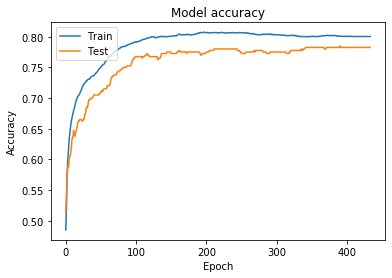

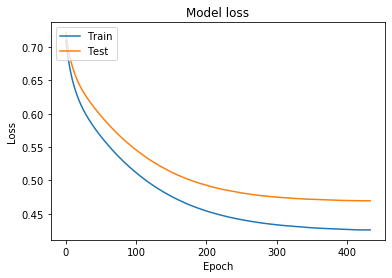

In [95]:
early_stp = EarlyStopping(monitor='val_loss', 
                          min_delta=0, patience=5, 
                          verbose=1, mode='auto', 
                          baseline=None, restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0000001)

# model.fit(X_train, Y_train, callbacks=[reduce_lr])

model = logreg
history = logreg.fit(X, y, 
                     epochs = 2000,
                     validation_data = (X_val, y_val),
                     callbacks=[reduce_lr, early_stp])

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Precision-recall curve

In [87]:
from sklearn.metrics import precision_recall_curve

In [ ]:
sklearn.metrics.precision_recall_curve(y_true, 
                                       probas_pred, 
                                       pos_label=None, 
                                       sample_weight=None)

In [107]:
y_true = test_data.targets
y_true.shape

(400,)

In [117]:
y_pred = logreg.predict(X_val)
y_pred.shape

(400, 1)

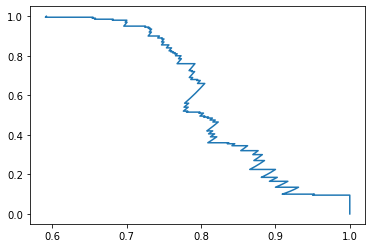

In [121]:
 precision, recall, thresholds = sklearn.metrics.precision_recall_curve(
                                       y_true, 
                                       y_pred, 
                                       pos_label=None, 
                                       sample_weight=None)
plt.plot(precision, recall);

In [124]:
average_precision = average_precision_score(y_true, y_pred)
average_precision

0.826655245637874

In [ ]:
# 0

In [137]:
test_data_0 = test_data.loc[test_data.targets==0]
test_data_0.shape

(200, 2)

In [147]:
X_val_0 = np.array(test_data_0.features.tolist()).reshape(200, 5)

In [151]:
y_true_0 = test_data_0.targets
y_pred_0 = logreg.predict(X_val_0)

In [182]:
len(np.where( y_pred_0 > 0.5 )[1])

59

In [ ]:
# 1

In [175]:
test_data_1 = test_data.loc[test_data.targets==1]
test_data_1.shape

(200, 2)

In [176]:
X_val_1 = np.array(test_data_1.features.tolist()).reshape(200, 5)

In [178]:
y_pred_1 = logreg.predict(X_val_1)
y_true_1 = test_data_1.targets

In [183]:
len(np.where( y_pred_1 < 0.5 )[1])

26

# NN

In [115]:
# NN
inputs = Input(shape=(5,))
dense = Dense(5, activation='relu')(inputs)
output = Dense(1, activation='sigmoid')(dense)
NN = Model(inputs, output)

NN.compile(optimizer='sgd',
                       loss = 'binary_crossentropy',
                       metrics=['accuracy'])
NN.optimizer.lr = 0.001
history_NN = NN.fit(X, y, 
                     epochs = 200, 
                     validation_data = (X_val, y_val))

Train on 3600 samples, validate on 400 samples
Epoch 1/200
3600/3600 [==============================] - 1s 245us/step - loss: 0.6523 - acc: 0.6711 - val_loss: 0.6503 - val_acc: 0.6875
Epoch 2/200
3600/3600 [==============================] - 0s 77us/step - loss: 0.6488 - acc: 0.6908 - val_loss: 0.6468 - val_acc: 0.7000
Epoch 3/200
3600/3600 [==============================] - 0s 53us/step - loss: 0.6453 - acc: 0.6978 - val_loss: 0.6434 - val_acc: 0.7075
Epoch 4/200
3600/3600 [==============================] - 0s 58us/step - loss: 0.6420 - acc: 0.7031 - val_loss: 0.6401 - val_acc: 0.7175
Epoch 5/200
3600/3600 [==============================] - 0s 82us/step - loss: 0.6387 - acc: 0.7097 - val_loss: 0.6369 - val_acc: 0.7200
Epoch 6/200
3600/3600 [==============================] - 0s 80us/step - loss: 0.6355 - acc: 0.7119 - val_loss: 0.6337 - val_acc: 0.7250
Epoch 7/200
3600/3600 [==============================] - 0s 60us/step - loss: 0.6323 - acc: 0.7158 - val_loss: 0.6305 - val_acc: 0.7275


Epoch 120/200
3600/3600 [==============================] - 0s 52us/step - loss: 0.4741 - acc: 0.7839 - val_loss: 0.4796 - val_acc: 0.7825
Epoch 121/200
3600/3600 [==============================] - 0s 52us/step - loss: 0.4737 - acc: 0.7833 - val_loss: 0.4792 - val_acc: 0.7825
Epoch 122/200
3600/3600 [==============================] - 0s 50us/step - loss: 0.4733 - acc: 0.7831 - val_loss: 0.4789 - val_acc: 0.7825
Epoch 123/200
3600/3600 [==============================] - 0s 43us/step - loss: 0.4730 - acc: 0.7831 - val_loss: 0.4786 - val_acc: 0.7825
Epoch 124/200
3600/3600 [==============================] - 0s 52us/step - loss: 0.4726 - acc: 0.7822 - val_loss: 0.4783 - val_acc: 0.7850
Epoch 125/200
3600/3600 [==============================] - 0s 51us/step - loss: 0.4723 - acc: 0.7825 - val_loss: 0.4779 - val_acc: 0.7825
Epoch 126/200
3600/3600 [==============================] - 0s 48us/step - loss: 0.4719 - acc: 0.7822 - val_loss: 0.4777 - val_acc: 0.7825
Epoch 127/200
3600/3600 [=========

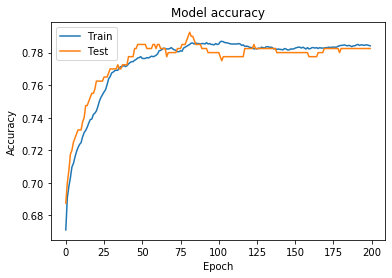

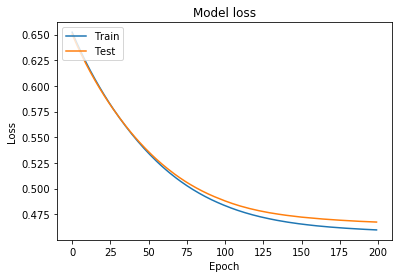

In [116]:
# Plot training & validation accuracy values
plt.plot(history_NN.history['acc'])
plt.plot(history_NN.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history_NN.history['loss'])
plt.plot(history_NN.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Recorded audios

In [269]:
voiceprint = [
'/Users/greenapple/project5/data/recorded/k_1.wav',
'/Users/greenapple/project5/data/recorded/k_2.wav',
'/Users/greenapple/project5/data/recorded/k_3.wav',
'/Users/greenapple/project5/data/recorded/k_4.wav',
'/Users/greenapple/project5/data/recorded/k_5.wav'
]

k_test = '/Users/greenapple/project5/data/recorded/k_det.wav'
m_test = '/Users/greenapple/project5/data/recorded/m_nint.wav'
m_attack = '/Users/greenapple/project5/data/recorded/m_attack.wav'

In [ ]:
# Load models
# Siamese. NB: run siamese_same_weights cell.
weights = '/Users/greenapple/project5/notebooks/siamese_same_weights_bal_900.h5'
model = siamese_same_weights
model.load_weights(weights)
# Logreg
logreg = load_model('/Users/greenapple/project5/models/logreg.h5')

In [194]:
# file to VGG16 embeddings
embeddings = audio_to_features.file_to_VGG16_features(k_test)
embeddings.shape

(7, 7, 512)

In [244]:
# 2 recordings. Returns siamese prob
# VGG16 embeddings
emb2 = audio_to_features.file_to_VGG16_features(k_test)
emb1 = audio_to_features.file_to_VGG16_features(voiceprint[0])

# A pair for siamese model. 
pair = [emb1, emb2]
X_siam = np.array(pair)
X_siam = np.reshape(X_siam, (1, 2, 7, 7, 512))
pairs_k = [(k_embs, embds) for embds in voiceprint_embds]
X_siam_k = np.array(pairs_k)

# Siamese model for one pair. Returns prob
prob = model.predict([X_siam[:,0], X_siam[:,1]])
prob

array([[0.9986149]], dtype=float32)

In [274]:
# Probability of a test audio belonging to the same speaker as the voiceprint

# Test VGG16 embeddings:
k_embs = audio_to_features.file_to_VGG16_features(k_test)
m_embs = audio_to_features.file_to_VGG16_features(m_test)
m_attack_embs = audio_to_features.file_to_VGG16_features(m_attack)

# Voiceprint VGG16 embeddings:
voiceprint_embds = []
for file in voice_print:
    embeddings = audio_to_features.file_to_VGG16_features(file)
    voiceprint_embds.append(embeddings)

# 5 pairs for siamese model.
pairs_k = [(k_embs, embds) for embds in voiceprint_embds]
X_siam_k = np.array(pairs_k)

pairs_m = [(m_embs, embds) for embds in voiceprint_embds]
X_siam_m = np.array(pairs_m)

pairs_a = [(m_attack_embs, embds) for embds in voiceprint_embds]
X_siam_a = np.array(pairs_a)

# Siamese model for pairs. Returns prob
probs_k = model.predict([X_siam_k[:,0], X_siam_k[:, 1]])
probs_m = model.predict([X_siam_m[:,0], X_siam_m[:, 1]])
probs_a = model.predict([X_siam_a[:,0], X_siam_a[:, 1]])

# Reshape for logreg 5-voiceprint model
X_logreg_k = np.reshape(probs_k, (1, 5))
X_logreg_m = np.reshape(probs_m, (1, 5))
X_logreg_a = np.reshape(probs_a, (1, 5))

# Logreg model
test_prob_k = logreg.predict(X_logreg_k)
test_prob_m = logreg.predict(X_logreg_m)
test_prob_a = logreg.predict(X_logreg_a)

# Results
test_prob_k, test_prob_m, test_prob_a

(array([[0.9468449]], dtype=float32),
 array([[0.13592465]], dtype=float32),
 array([[0.8595168]], dtype=float32))

In [276]:
# Check audios
audio, sr = librosa.load(m_test, sr=16000, offset=0.4, duration=3)
# audio, sr = librosa.load(voiceprint[1], sr=16000, offset=0.4)
Audio(audio, rate=sr)

In [ ]:
model = siamese_same_weights
trials = 1
speaker_data = test_data_40_vgg

lst = applications.one_speaker_authentification_1(model, trials, speaker_data)
lst

# Wave plots

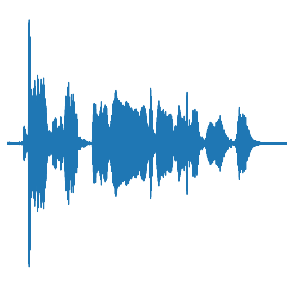

<Figure size 432x288 with 0 Axes>

In [307]:
audio, sr = librosa.load(m_attack, sr=16000, offset=1.5, duration=2.5)
plt.figure(figsize=(5, 5))
figure = librosa.display.waveplot(audio, sr=sr)
# figure.axes.get_xaxis().set_visible(False)
# figure.axes.get_yaxis().set_visible(False)
plt.axis('off')
plt.show();
plt.savefig('/Users/greenapple/project5/reports/figures/attack.png')

# Siamese error analysis

In [238]:
# Siamese probs
speaker_data = test_data_40_vgg
trials = 1
n = 5

probs, ids = applications.one_speaker_authentification_1(model, 
                                                         trials, 
                                                         speaker_data, 
                                                         n)
probs

array([[0.04250462],
       [0.99905103],
       [0.92333823],
       [0.07852192],
       [0.9970149 ]], dtype=float32)

In [244]:
# Audio files
ids

['672-122797-0054.flac',
 '672-122797-0003.flac',
 '672-122797-0019.flac',
 '672-122797-0055.flac',
 '672-122797-0074.flac',
 '672-122797-0042.flac']

In [243]:
ids[4]

'672-122797-0074.flac'

In [250]:
# Check audios. 
# Librosa no longer plays audios in Chrome (after an update). Use Firefox.
folder = '/Users/greenapple/project5/data/raw/LibriSpeech/test-clean'
file_name = ids[0]
sub_f_1 = file_name.split('-')[0]
sub_f_2 = file_name.split('-')[1]
file = os.path.join(folder, sub_f_1, sub_f_2, file_name)
audio, sr = librosa.load(file, sr=16000, offset=0.4, duration=3.8)
# audio, sr = librosa.load(voiceprint[1], sr=16000, offset=0.4)
Audio(audio, rate=sr)

In [246]:
path = '/Users/greenapple/project5/reports/wavs/file_1_1.wav'
librosa.output.write_wav(path, audio, sr, norm=False)

In [251]:
path = '/Users/greenapple/project5/reports/wavs/file_1_2.wav'
librosa.output.write_wav(path, audio, sr, norm=False)

In [213]:
# Different speaker
model = siamese_same_weights
trials = 1
speaker_data = test_data_40_vgg
n = 5

lst = applications.one_speaker_authentification_0(model, 
                                                  trials, 
                                                  speaker_data, 
                                                  n)
lst

array([[0.9840262 ],
       [0.37477568],
       [0.09450543],
       [0.8675668 ],
       [0.09639307]], dtype=float32)

In [ ]:
# Speakers who are not predicted well by the model make "change" their voice
# to represent a character (data are from audio books).